### Etavas para a criação do MVP 

 - Encontrar um mecanismo que transforme as informações encontradas no modelo em posições em um portfolio 
 - Encontrar um mecanismo que gerencie a volatilidade da estratégia final de forma ótima

In [1]:
### Retorno ibovespa

import pandas as pd
import yfinance as yf
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import black_scholes as bs
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
#import minimize
from scipy.optimize import minimize
from time import sleep
from IPython.display import clear_output, display
from scipy import interpolate

# Defina o intervalo de datas para o histórico desejado

# Obtenha os dados do índice IBOVESPA

df = pd.read_excel('Randominput.xlsx')
## Greeks today

df['Delta'] = bs.bs_call_delta(df['Spot']/2+df['Spot_y']/2, df['Strike'], df['Matur'], df['Rate'], df['Sigma']/2+df['Sigma_y']/2 )
df['Gamma'] = bs.bs_call_gamma(df['Spot']/2+df['Spot_y']/2, df['Strike'], df['Matur'], df['Rate'], df['Sigma']/2+df['Sigma_y']/2 )
df['Vega'] = bs.bs_call_vega(df['Spot']/2+df['Spot_y']/2, df['Strike'], df['Matur'], df['Rate'], df['Sigma']/2+df['Sigma_y']/2 )
df['Rho'] = bs.bs_call_rho(df['Spot']/2+df['Spot_y']/2, df['Strike'], df['Matur'], df['Rate'], df['Sigma']/2+df['Sigma_y']/2 )
df['Theta'] = bs.bs_call_theta(df['Spot']/2+df['Spot_y']/2, df['Strike'], df['Matur'], df['Rate'], df['Sigma']/2+df['Sigma_y']/2 )

df['Price_y'] = bs.bs_call(df['Spot_y'], df['Strike'], df['Matur'], df['Rate'], df['Sigma_y'])

df['Excess_return'] = df['Price_y'] - df['Price']
df['Expected_volatility'] = df['Delta'] * df['Spot_std'] + df['Vega'] * df['Sigma_std']
df['T_return'] = df['Excess_return'] / df['Expected_volatility']




In [2]:

df_squad = df.pivot_table(index='Code', columns='Code')['Delta'].fillna(0)

for coluna in df_squad.columns:
    for linha in df_squad[coluna:].index:
        if coluna != linha:
            
            delta_1 = df[df['Code']==coluna]['Delta'].values[0]
            delta_2 = df[df['Code']==linha]['Delta'].values[0]

            vega_1 = df[df['Code']==coluna]['Vega'].values[0]
            vega_2 = df[df['Code']==linha]['Vega'].values[0]

            spot_vol = df[df['Code']==coluna]['Spot_std'].values[0]
            sigma_vol = df[df['Code']==linha]['Sigma_std'].values[0]

            cov_i = delta_1 * delta_2 * spot_vol**2 + vega_1 * vega_2 * sigma_vol**2 #Vamos assumir que residuo dos modelos tem correlação 0,   (Deveriam ter, se tiverem alguma correlação há espaço para otimização dos modelos anteriores, além de ser muito improvavel de ter, basta imaginar que o residuo deveria ser um ruído branco, embora tenha a possibilidade de ter correlação, não é o caso mais provavel)
            
            df_squad.loc[coluna,linha] = cov_i
            df_squad.loc[linha,coluna] = cov_i


cov_matrix = df_squad

In [3]:


def objective(weights):
    ret = df[ 'Excess_return'].T.dot(weights)
    vol = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    return -ret/vol



targuet =  (df['T_return'].abs() > df['T_return'].abs().median())/20


bnds = tuple((-.1,.1) for x in range(len(df)))
bnds2 = tuple((-.1,.1) if abs(x)>df['T_return'].abs().median() else (0,0) for x in (df['T_return']) )

res = minimize(objective, targuet, method='SLSQP', bounds=bnds)
res_2 = minimize(objective, targuet, method='SLSQP', bounds=bnds2)



df['Weights'] = res.x
df['Weights_2'] = res_2.x


df['Weights'] = df['Weights'] / df['Excess_return'].dot(df['Weights'])
df['Weights_2'] = df['Weights_2'] / df['Excess_return'].dot(df['Weights_2'])

clear_output()



In [4]:

a,b = np.linalg.pinv(df[['Delta', 'Gamma', 'Vega', 'Rho', 'Theta']].values)[[0,2]]

a = 10 * a/df['Excess_return'].dot(a)
b = 10 * b/df['Excess_return'].dot(b)

def objective_null_1(vect):
    a_w , b_w = vect
    weights = a_w * a + b_w * b
    gross = abs(weights).sum()
    return gross

def objective_null_2(vect):
    a_w , b_w = vect
    weights = a_w * a + b_w * b
    diversification = np.quantile(weights,.25) - np.quantile(weights,.75)
    return diversification

def objective_null_3(vect):
    a_w , b_w = vect
    weights = a_w * a + b_w * b
    expct_ret = df['Excess_return'].dot(weights)
    expct_ret = expct_ret[expct_ret < 0]
    return -expct_ret.sum()


def objective_null_4(vect):
    a_w , b_w = vect
    weights = a_w * a + b_w * b
    expct_ret = np.abs(df['T_return'].dot(weights))

    return -expct_ret.sum()

cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - 1})
bnds = ((-5,5),(-5,5) )

res_null_1 = minimize(objective_null_1, (0.5,0.5), method='SLSQP', constraints=cons, bounds=bnds)
res_null_2 = minimize(objective_null_2, (0.5,0.5), method='SLSQP', constraints=cons, bounds=bnds)
res_null_3 = minimize(objective_null_3, (0.5,0.5), method='SLSQP', constraints=cons, bounds=bnds)
res_null_4 = minimize(objective_null_4, (0.5,0.5), method='SLSQP', constraints=cons, bounds=bnds)

df['Weights_null_1'] = res_null_1.x[0] * a + res_null_1.x[1] * b
df['Weights_null_2'] = res_null_2.x[0] * a + res_null_2.x[1] * b
df['Weights_null_3'] = res_null_3.x[0] * a + res_null_3.x[1] * b
df['Weights_null_4'] = res_null_4.x[0] * a + res_null_4.x[1] * b

clear_output()


In [178]:
linear = np.linspace(0.0001,0.9999,20)

spots = linear*8.2 - 4 + df['Spot_y'].mean()

sigmas = linear * .41


## Cross join betwen spots and sigma

df_cross = pd.DataFrame({'Spot_y':spots, 'key': 1})
df_cross = df_cross.merge(pd.DataFrame({'Sigma_multi':sigmas, 'key': 1}), on='key')


df2 = df[['Code','Spot','Strike','Matur','Sigma','Rate','Price','Weights_2']]

df_cross['key'] = 1
df2['key'] = 1

df_cross = df_cross.merge(df2, on='key')
df_cross['Sigma_y'] = df_cross['Sigma_multi'] + df_cross['Sigma']



df_cross['Price_y'] = bs.bs_call(df_cross['Spot_y'], df_cross['Strike'], df_cross['Matur'], df_cross['Rate'], df_cross['Sigma_y'] )

df_cross['Gain'] = df_cross['Price_y'] - df_cross['Price']


df_cross['Profit'] = (df_cross['Gain'] * (df_cross['Weights_2']) ) **3

df_plot = df_cross[['Spot_y','Sigma_multi','Profit']].groupby(['Spot_y','Sigma_multi']).sum().reset_index()

df_plot['Sigma_y'] = df_plot['Sigma_multi'] + df['Sigma'].mean()

clear_output()

C:\Users\diogo\AppData\Local\Temp\ipykernel_5436\938180148.py:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


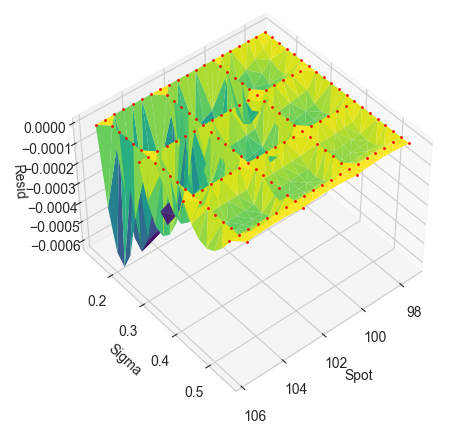

In [180]:
x = df_plot['Spot_y']
y = df_plot['Sigma_multi']

spot_mask = x.apply(lambda i: i in np.unique(x)[0:20:6])
sigma_mask = y.apply(lambda i: i in np.unique(y)[0:20:6])

input_df = df_plot[spot_mask + sigma_mask]

input_df = input_df[['Spot_y','Sigma_multi','Sigma_y','Profit']]

# Interpolação bidimensional

f = interpolate.LinearNDInterpolator(input_df[['Spot_y','Sigma_y']].values, input_df['Profit'].values)

df_plot['Bi-Interpolate'] = f(df_plot['Spot_y'], df_plot['Sigma_y'])

df_plot['Resid_3'] = (df_plot['Profit'] - df_plot['Bi-Interpolate'])

## Plot resid surface

x = df_plot['Spot_y']
y = df_plot['Sigma_y']
z = df_plot['Resid_3']


# Fzer os dois plots tridimensionais um ao lado do outro, um referente ao residuo e outro referente a probabilidade

fig = plt.figure(figsize=(30,5) )
ax = fig.gca(projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.001, antialiased=True)
ax.view_init(45, 50)

ax.set_xlabel('Spot')
ax.set_ylabel('Sigma')
ax.set_zlabel('Resid')

ax.plot(input_df['Spot_y'], input_df['Sigma_y'], 0, color='red', linewidth=.001, marker='o', markersize=1, label='Input points')

plt.show()




###





C:\Users\diogo\AppData\Local\Temp\ipykernel_5436\1515557693.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


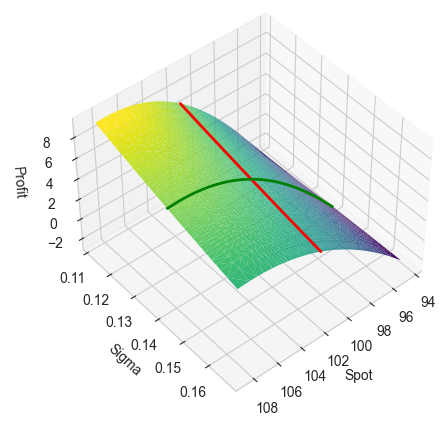

In [70]:


# Make the plot 
fig = plt.figure(figsize=(30,5) )
ax = fig.gca(projection='3d')

df_plot['Profit'] = df_plot['Profit']*1000 - 5

x = df_plot['Spot_y']
y = df_plot['Sigma_y']
z = df_plot['Profit'] 


surf = ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.001, antialiased=True)
ax.view_init(45, 50)

ax.set_xlabel('Spot')
ax.set_ylabel('Sigma')
ax.set_zlabel('Profit')

spot_mask = x == x.drop_duplicates().values[30]
x_1 = x[spot_mask]
y_1 = y[spot_mask]
z_1 = z[spot_mask]

ax.plot(x_1, y_1, z_1, color='red', linewidth=2, label='g_1')


sigma_mask = y == y.drop_duplicates().values[30]
x_2 = x[sigma_mask]
y_2 = y[sigma_mask]
z_2 = z[sigma_mask]

ax.plot(x_2, y_2, z_2, color='green', linewidth=2, label='g_2')


plt.show()



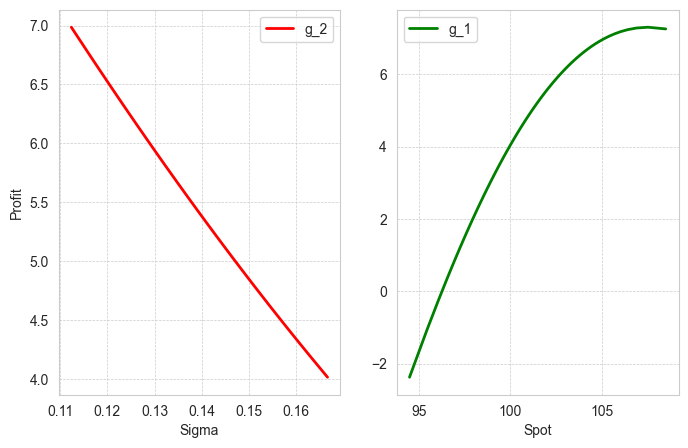

In [71]:
# Plot y_1 e z_1 no plot comum lineplot (2d)

fig,ax = plt.subplots(1,2,figsize=(8,5))

# Grid pontilhado 

ax[0].grid(linestyle='--', linewidth=0.5)
ax[1].grid(linestyle='--', linewidth=0.5)


ax[0].plot(y_1, z_1, color='red', linewidth=2, label='g_2')
ax[1].plot(x_2,z_2,color='green', linewidth=2, label='g_1')


ax[0].set_xlabel('Sigma')
ax[0].set_ylabel('Profit')

ax[1].set_xlabel('Spot')

ax[0].legend()
ax[1].legend()




In [111]:
delta = (g1(101) - g1(100))
vega = (g2(0.13949) - g2(0.13)) / (.13949 - .13)

In [110]:
y_1.median()

0.13949257497235193

In [112]:
g1 = interpolate.interp1d( x_2, z_2)
g2 = interpolate.interp1d( y_1, z_1)

df_plot = df_plot[df_plot['Spot_y'] < x_2.max()]
df_plot = df_plot[df_plot['Spot_y'] > x_2.min()]

df_plot = df_plot[df_plot['Sigma_y'] < y_1.max()]
df_plot = df_plot[df_plot['Sigma_y'] > y_1.min()]

df_plot['Profit_est'] = df_plot['Spot_y'].apply(g1) + df_plot['Sigma_y'].apply(g2) - df_plot[sigma_mask & spot_mask]['Profit'].values[0]
df_plot['ComumEstimate'] =df_plot[sigma_mask & spot_mask]['Profit'].values[0] + delta * (df_plot['Spot_y'] - 100) + vega * (df_plot['Sigma_y'] - 0.1395)


df_plot['Resid'] = (df_plot['Profit'] - df_plot['Profit_est']) *0.3
df_plot['Resid_2'] = (df_plot['Profit'] - df_plot['ComumEstimate']) *0.5


C:\Users\diogo\AppData\Local\Temp\ipykernel_5436\76007632.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot['Profit_est'] = df_plot['Spot_y'].apply(g1) + df_plot['Sigma_y'].apply(g2) - df_plot[sigma_mask & spot_mask]['Profit'].values[0]
C:\Users\diogo\AppData\Local\Temp\ipykernel_5436\76007632.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot['ComumEstimate'] =df_plot[sigma_mask & spot_mask]['Profit'].values[0] + delta * (df_plot['Spot_y'] - 100) + vega * (df_plot['Sigma_y'] - 0.1395)


C:\Users\diogo\AppData\Local\Temp\ipykernel_5436\3874901764.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


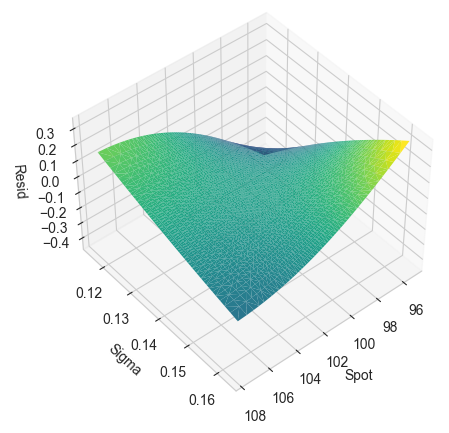

In [105]:
## Plot resid surface

x = df_plot['Spot_y']
y = df_plot['Sigma_y']
z = df_plot['Resid']
z2 = df_plot['Probability'] / df_plot['Probability'].sum()


# Fzer os dois plots tridimensionais um ao lado do outro, um referente ao residuo e outro referente a probabilidade

fig = plt.figure(figsize=(30,5) )
ax = fig.gca(projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.001, antialiased=True)
ax.view_init(45, 50)

ax.set_xlabel('Spot')
ax.set_ylabel('Sigma')

ax.set_zlabel('Resid')

plt.show()




###




In [145]:
#np.unique(x)[0:56:14]



1802     True
1742    False
1682    False
1862    False
1622    False
        ...  
3476    False
3417    False
237     False
177      True
3477    False
Name: Spot_y, Length: 3136, dtype: bool

,Spot_y,Sigma_multi,Profit,Sigma_y,Profit_est,Resid,Probability,ComumEstimate,Resid_2,Bi-Interpolate,Resid_3
1802,101.570143,-0.023358,6.635611,0.116135,6.660567,-0.007487,5.308099e-01,7.965677,-0.665033,6.635611,0.000000
1742,101.429857,-0.023358,6.511391,0.116135,6.561818,-0.015128,5.308099e-01,7.850250,-0.669430,6.511391,0.000000
1682,101.289445,-0.023358,6.384161,0.116135,6.460616,-0.022936,5.156829e-01,7.734719,-0.675279,6.384161,0.000000
1862,101.710555,-0.023358,6.757037,0.116135,6.757037,0.000000,5.156829e-01,8.081208,-0.662086,6.757037,0.000000
1622,101.148650,-0.023358,6.253685,0.116135,6.356770,-0.030926,4.866079e-01,7.618874,-0.682594,6.253685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3476,107.527273,0.020935,5.865871,0.160428,6.252629,-0.116027,2.973677e-12,10.387432,-2.260781,NaN,NaN
3417,106.902174,0.023358,5.696102,0.162850,6.111900,-0.124739,2.687244e-10,9.737478,-2.020688,NaN,NaN
237,96.097826,0.023358,-0.367178,0.162850,-1.394204,0.308108,2.687244e-10,0.847670,-0.607424,-0.456000,0.088822
177,95.472727,0.023358,-1.046150,0.162850,-2.212650,0.349950,1.423046e-12,0.333339,-0.689745,-1.046150,0.000000


C:\Users\diogo\AppData\Local\Temp\ipykernel_5436\915696060.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


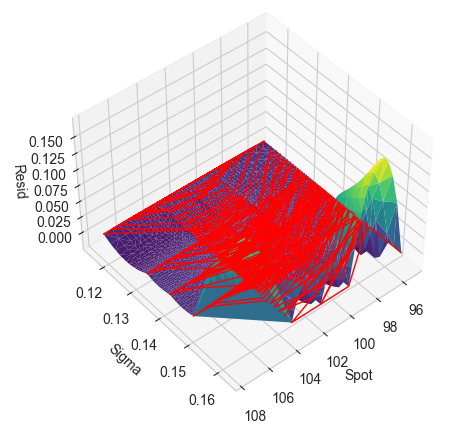

In [272]:
hksao

def objective_hc1(weights): # E[X] + CVaR.95(X)
    weights_df = df[['Code']]
    weights_df['Weights'] = weights
    profit_df = df_cross.merge(weights_df, on='Code')
    profit_df['Profit'] = profit_df['Gain'] * profit_df['Weights']
    profit_df = profit_df.groupby(['Spot_y', 'Sigma_y'])['Profit'].sum().reset_index()
    ret = profit_df['Profit'].mean()
    risk = profit_df['Profit'].quantile(.05)
    risk = profit_df[profit_df['Profit'] <= risk]['Profit'].mean()
    return -(ret + risk)



def objective_hc2(weights): # E[X] + VaR.95(X)
    weights_df = df[['Code']]
    weights_df['Weights'] = weights
    profit_df = df_cross.merge(weights_df, on='Code')
    profit_df['Profit'] = profit_df['Gain'] * profit_df['Weights']
    profit_df = profit_df.groupby(['Spot_y', 'Sigma_y'])['Profit'].sum().reset_index()
    ret = profit_df['Profit'].mean()
    risk = profit_df['Profit'].quantile(.05)
    return -(ret + risk)




def objective_hc3(weights): # E[X] * Prob(X > 0)
    weights_df = df[['Code']]
    weights_df['Weights'] = weights
    profit_df = df_cross.merge(weights_df, on='Code')
    profit_df['Profit'] = profit_df['Gain'] * profit_df['Weights']
    profit_df = profit_df.groupby(['Spot_y', 'Sigma_y'])['Profit'].sum().reset_index()
    ret = profit_df['Profit'].mean()
    probwin = np.mean(profit_df['Profit']>0)
    return -(ret*probwin )



def objective_hc4(weights): # CVaR.95(X) / Prob(X < 0)
    weights_df = df[['Code']]
    weights_df['Weights'] = weights
    profit_df = df_cross.merge(weights_df, on='Code')
    profit_df['Profit'] = profit_df['Gain'] * profit_df['Weights']
    profit_df = profit_df.groupby(['Spot_y', 'Sigma_y'])['Profit'].sum().reset_index()
    risk = profit_df['Profit'].quantile(.05)
    risk = profit_df[profit_df['Profit'] <= risk]['Profit'].mean()
    probloss = np.mean(profit_df['Profit']<0)
    return -(risk/probloss )



bnds = tuple((-.2,.2) for x in range(len(df)))

res_hc1 = minimize(objective_hc1, df['Weights'], method='SLSQP', bounds=bnds)
res_hc2 = minimize(objective_hc2, df['Weights'], method='SLSQP', bounds=bnds)
res_hc3 = minimize(objective_hc3, df['Weights'], method='SLSQP', bounds=bnds)
res_hc4 = minimize(objective_hc4, df['Weights'], method='SLSQP', bounds=bnds)

df['Weights_hc1'] = res_hc1.x
df['Weights_hc2'] = res_hc2.x
df['Weights_hc3'] = res_hc3.x
df['Weights_hc4'] = res_hc4.x

clear_output()


C:\Users\diogo\AppData\Local\Temp\ipykernel_2016\1148252563.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
C:\Users\diogo\AppData\Local\Temp\ipykernel_2016\1148252563.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar( surf, shrink=0.5, aspect=5)


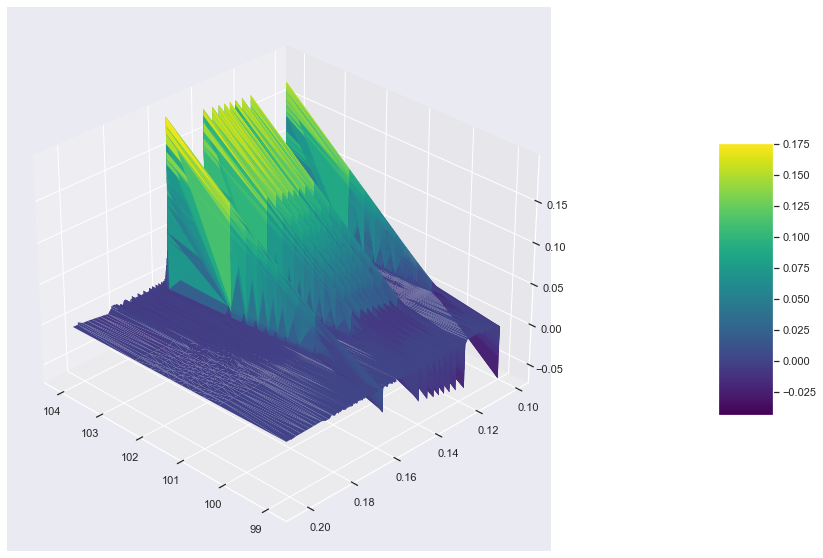

In [189]:
# Make the plot
i = 135
fig = plt.figure(figsize=(60,10) )
ax = fig.gca(projection='3d')
#surf = ax.plot_trisurf(df_plot['Spot_y'], df_plot['Sigma_y'], df_plot['Gain_W1'], cmap=plt.cm.viridis, linewidth=0.001) # abaixo o plot mais suavizado
surf = ax.plot_trisurf(df_plot['Spot_y'], df_plot['Sigma_y'], df_plot['Profit'], cmap=plt.cm.viridis, linewidth=0.001, antialiased=True)

fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, i)
plt.show()



In [30]:
### Vamos criar um random walk com volatilidade volatil 

def stock_sim(start=1, vol=0.01, n=1000):
    walk = [start]
    vols = [vol]

    
    vol_i = vol
    for i in range(n):
        vol_i = vol_i * np.random.normal(1,1)
        vol_i = abs(vol_i/2 + vol/2)
        walk_px = walk[-1] * 0.999 + start * 0.001 + np.random.normal(0,vols[-1])
        walk.append(walk_px)
        vols.append(vol_i)
    retorno_df = pd.DataFrame({'Walk': walk, 'Sigma_pop': vols})
    return retorno_df


vol_vol_regular = []
vol_vol_adjs = []

for _ in range(1000):
    mc_sim = stock_sim(1,0.01,1000)


    # Retorno Diário
    mc_sim['Return'] = mc_sim['Walk'].pct_change().fillna(0)

    # Volatilidade Diária
    mc_sim['Volatility'] = mc_sim['Walk'].pct_change().fillna(0)**2

    # Volatilidade móvel
    mc_sim['Volatility_mm20'] = mc_sim['Volatility'].rolling(20).mean()


    # Alavancagem
    mc_sim['Leverage'] = 1

    # Retorno Alavancado
    mc_sim['Return_Leverage'] = mc_sim['Return'] * mc_sim['Leverage'].shift(1)

    # Cota alavancada
    mc_sim['Walk_Leverage'] = (1+mc_sim['Return_Leverage']).cumprod()

    mc_sim.dropna(inplace=True)


    # Meta de volatilidade
    vol_targuet = 0.01


    # Modelo para alavancagem ideal
    mc_sim['Ideal_Levarage'] = (vol_targuet - mc_sim['Volatility_mm20']*19/20 ) / mc_sim['Sigma_pop']
    mc_sim['Ideal_Levarage'] = mc_sim['Ideal_Levarage'].clip(0,5)

    # Retorno Alavancado ideal
    mc_sim['Return_Leverage_Ideal'] = mc_sim['Return'] * mc_sim['Ideal_Levarage'].shift(1)

    # Cota alavancada ideal
    mc_sim['Walk_Leverage_Ideal'] = (1+mc_sim['Return_Leverage_Ideal']).cumprod()

    # Volatilidade alavancagem ideal

    mc_sim['Volatility_Leverage_Ideal'] = mc_sim['Return_Leverage_Ideal']**2
    mc_sim['Volatility_Leverage_Ideal'] = mc_sim['Volatility_Leverage_Ideal'].rolling(20).mean()


    vol_vol_natural = mc_sim['Volatility_mm20'].std() * np.sqrt(252)
    vol_vol_leverage = mc_sim['Volatility_Leverage_Ideal'].std() * np.sqrt(252)

    vol_vol_regular.append(vol_vol_natural)
    vol_vol_adjs.append(vol_vol_leverage)



c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\diogo\AppData\Local\Temp\ipykernel_19140\595895217.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
C:\Users\diogo\AppData\Local\Temp\ipykernel_19140\595895217.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


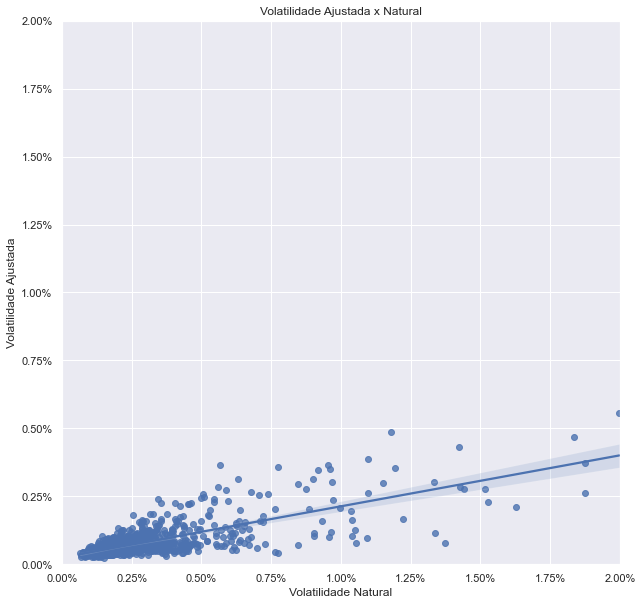

In [31]:
# Plot vol natural x adjust 

# Remove ouliers
vol_vol_regular = np.array(vol_vol_regular)
vol_vol_adjs = np.array(vol_vol_adjs)

mask_ = (vol_vol_regular < 0.02) & (vol_vol_adjs < 0.02)

vol_vol_regular = vol_vol_regular[mask_]
vol_vol_adjs = vol_vol_adjs[mask_]

fig, ax  = plt.subplots(figsize=(10,10))

sns.regplot(vol_vol_regular, vol_vol_adjs)
plt.xlabel('Volatilidade Natural')
plt.ylabel('Volatilidade Ajustada')
plt.title('Volatilidade Ajustada x Natural')

plt.xlim(0,0.02)
plt.ylim(0,0.02)

# X and Y axis in percentage 

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


plt.show()